<a href="https://colab.research.google.com/github/sanjaynagi/rna-seq-meta/blob/main/workflow/notebooks/misc/cluster-heatmaps-16-12-22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Heatmaps

In [20]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns

def load_candidates(analysis, name='median', func=np.nanmedian, query_annotation=None, query_fc=None):
    fc_data = pd.read_csv(f"https://raw.githubusercontent.com/sanjaynagi/rna-seq-meta/main/results/fcs.{analysis}.tsv", sep="\t")
    fc_data = fc_data.set_index(['GeneID', 'GeneName', 'GeneDescription'])

    if query_annotation is not None:
      gene_annot_df = load_annotations()
      gene_ids = gene_ids_from_annotation(gene_annot_df=gene_annot_df, annotation=query_annotation)
      fc_data = fc_data.query("GeneID in @gene_ids")
      assert not fc_data.empty, "No genes were found for the selection. It is possible these genes were removed by the ortholog finding process"
    
    fc_ranked = fc_data.apply(func, axis=1).to_frame().rename(columns={0:f'{name} log2 Fold Change'}).copy()
    fc_ranked = fc_ranked.sort_values(f'{name} log2 Fold Change', ascending=False)
    fc_ranked = fc_ranked.reset_index()
    fc_ranked.loc[:, f'{name} Fold Change'] = np.round(2**fc_ranked.loc[:, f'{name} log2 Fold Change'], 2)

    if query_fc is not None:
      fc_ranked = fc_ranked.query(f'`{name} Fold Change` > {query_fc}')

    return(fc_ranked)
    
def gene_ids_from_annotation(gene_annot_df, annotation):
    if isinstance(annotation, list):
        gene_list = np.array([])
        if annotation[0].startswith("GO"):
            for go in annotation:
                ids = gene_annot_df.query(f"GO_terms.str.contains('{go}', na=False)", engine='python')['gene_id'].to_numpy()
                gene_list = np.hstack([gene_list, ids])
            return(np.unique(gene_list))
        else:
            for dom in annotation:
                ids = gene_annot_df.query("domain == @annotation")['gene_id'].to_numpy()
                gene_list = np.hstack([gene_list, ids])
            return(np.unique(gene_list))
    else:
        if annotation.startswith("GO"): 
            return(gene_annot_df.query(f"GO_terms.str.contains('{annotation}', na=False)", engine='python')['gene_id'].to_numpy())
        else:
            return(gene_annot_df.query("domain == @annotation")['gene_id'].to_numpy())

def load_annotations():
    pfam_df = pd.read_csv("https://github.com/sanjaynagi/rna-seq-meta/blob/main/resources/Anogam_long.pep_Pfamscan.seqs.gz?raw=true", sep="\s+", header=None, compression='gzip')
    go_df = pd.read_csv("https://github.com/sanjaynagi/rna-seq-meta/blob/main/resources/Anogam_long.pep_eggnog_diamond.emapper.annotations.GO.gz?raw=true", sep="\t", header=None, compression='gzip')
    pfam_df.columns = ["transcript", "pstart", "pend", "pfamid", "domain", "domseq"]
    go_df.columns = ['transcript', 'GO_terms']

    gene_annot_df = pfam_df.merge(go_df)
    gene_annot_df.loc[:, 'gene_id'] = gene_annot_df.loc[:, 'transcript'].str.replace("Anogam_", "").str.replace("-R[A-Z]", "", regex=True)
    return(gene_annot_df)

def plot_heatmap(analysis, query_annotation=None, query_func=np.nanmedian, query_fc=None, query_name='median', cmap=None, cbar_pos=None, figsize=None):
    
    # load metadata
    fc_data = pd.read_csv(f"https://raw.githubusercontent.com/sanjaynagi/rna-seq-meta/main/results/fcs.{analysis}.tsv", sep="\t") 
    fc_ranked = load_candidates(analysis=analysis, name=query_name, func=query_func, query_annotation=query_annotation, query_fc=query_fc)
    fc_genes = fc_ranked.loc[:, 'GeneID']
    fam_data = fc_data.query("GeneID in @fc_genes").copy()
    
    fam_data.loc[:, 'Label'] = [id_ + " | " + name if name != "" else id_ for id_, name in zip(fam_data['GeneID'].fillna(""), fam_data['GeneName'].fillna(""))]
    fam_data = fam_data.set_index("Label").drop(columns=['GeneName', 'GeneID', 'GeneDescription'])
    fam_data.columns = [c.replace("_log2FoldChange", "").replace("_", " ") for c in fam_data.columns]
    mask = fam_data.isnull()

    if fam_data.empty or fam_data.shape[0] == 1:
      print(f"Too few observations for {query_annotation} and FC of greater than {query_fc}")
      return
    
    if not figsize:
        height = np.max([fam_data.shape[0]/2.5, 4])
        figsize = [10, height]

    cg = sns.clustermap(
        fam_data.fillna(0), 
        mask=mask, 
        cbar_pos=cbar_pos, 
        cmap=cmap,
        figsize=figsize, 
        tree_kws={'linewidths':3, 'colors':'darkgrey'},
        linewidths=2,
        yticklabels=True,
    )

    cg.ax_col_dendrogram.set_visible(False)

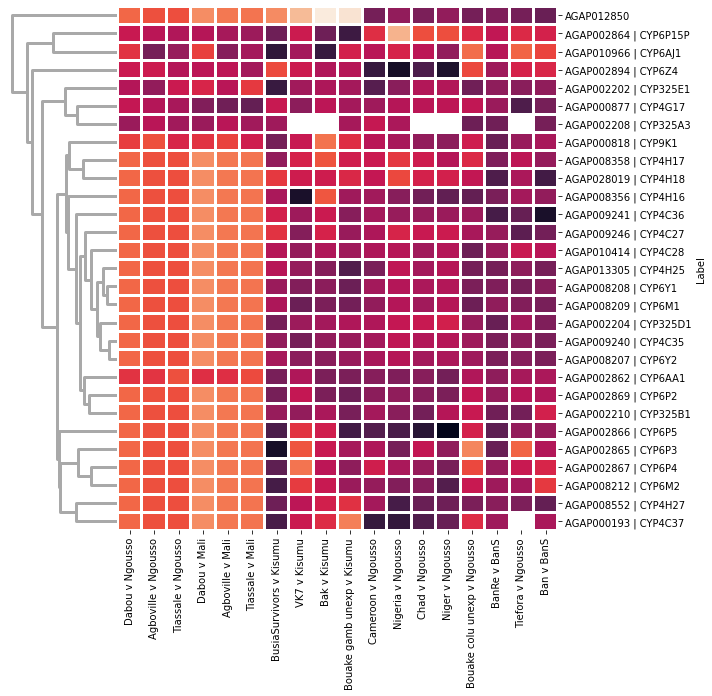

In [18]:
plot_heatmap(
    analysis='gamb_colu',
    query_annotation='p450',
    query_fc=1.8,
    )

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:1197: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(**tight_params)


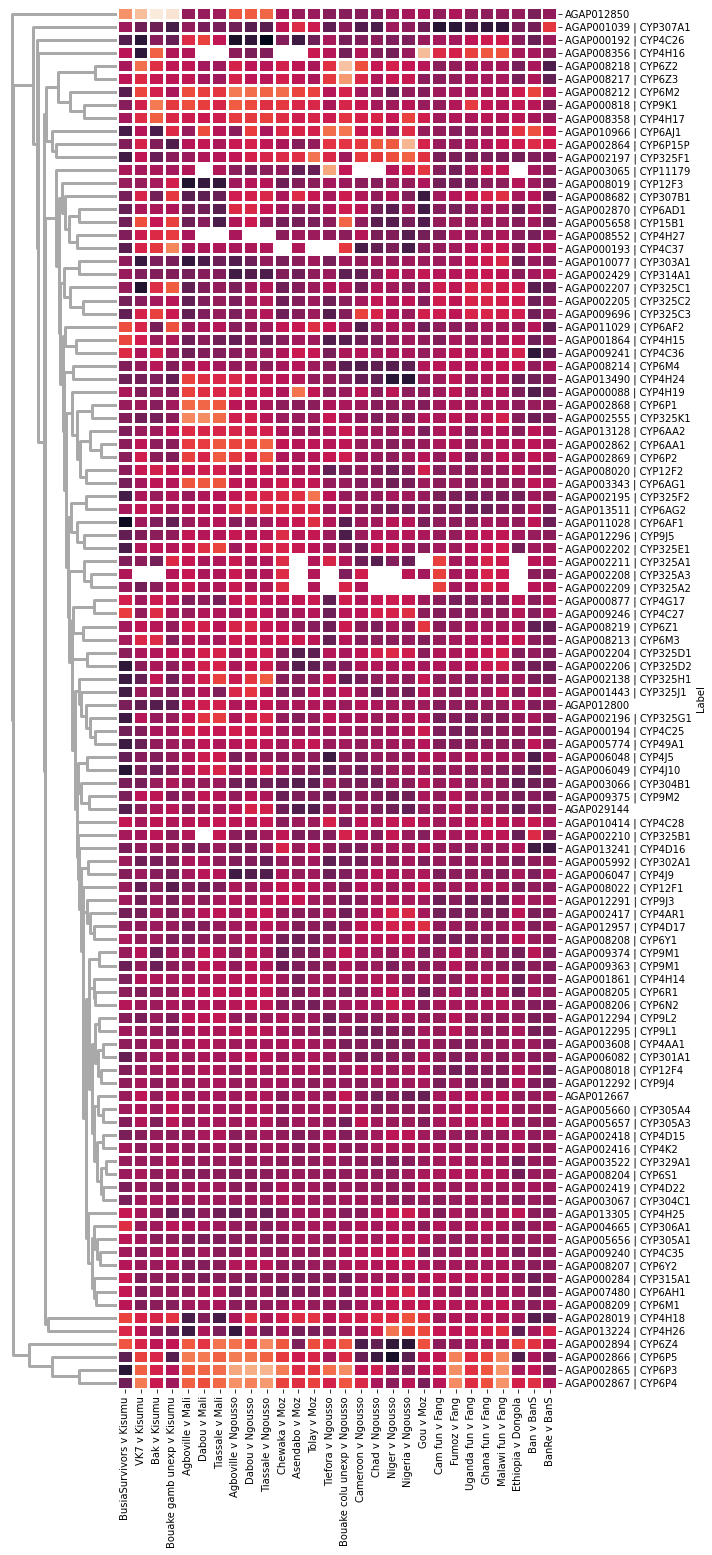

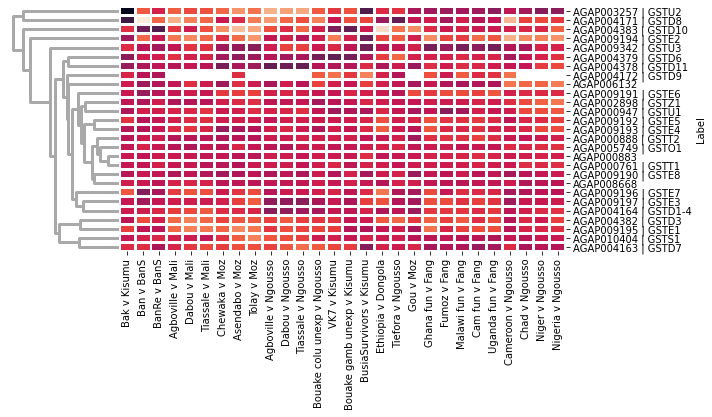

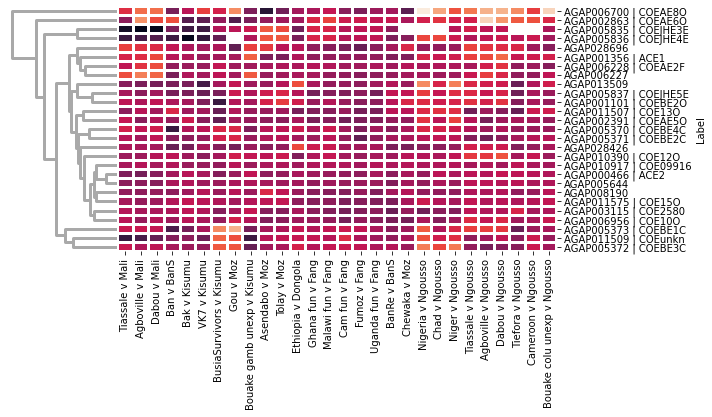

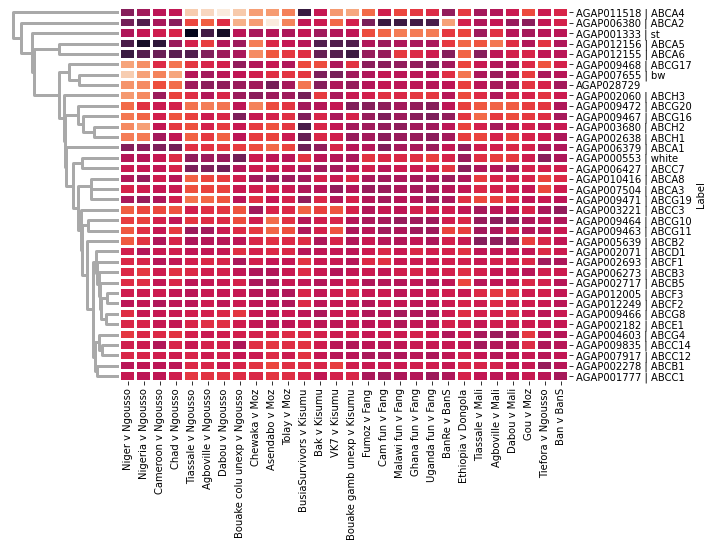

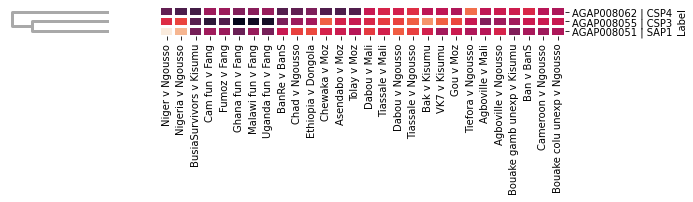

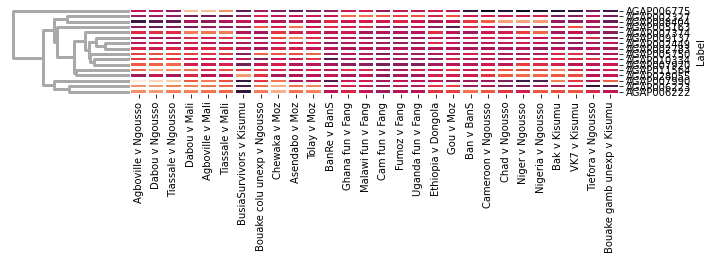

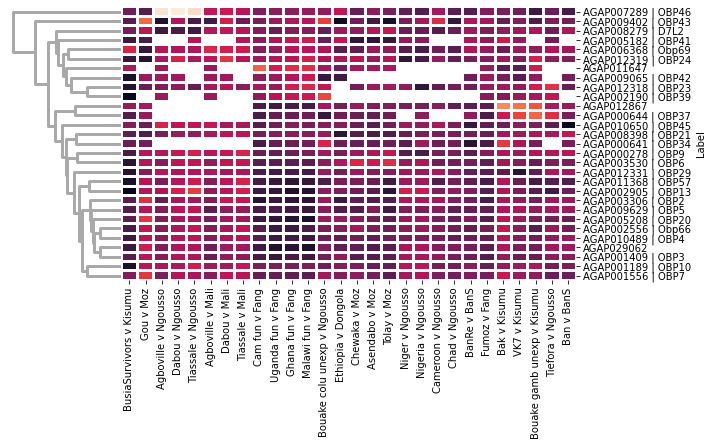

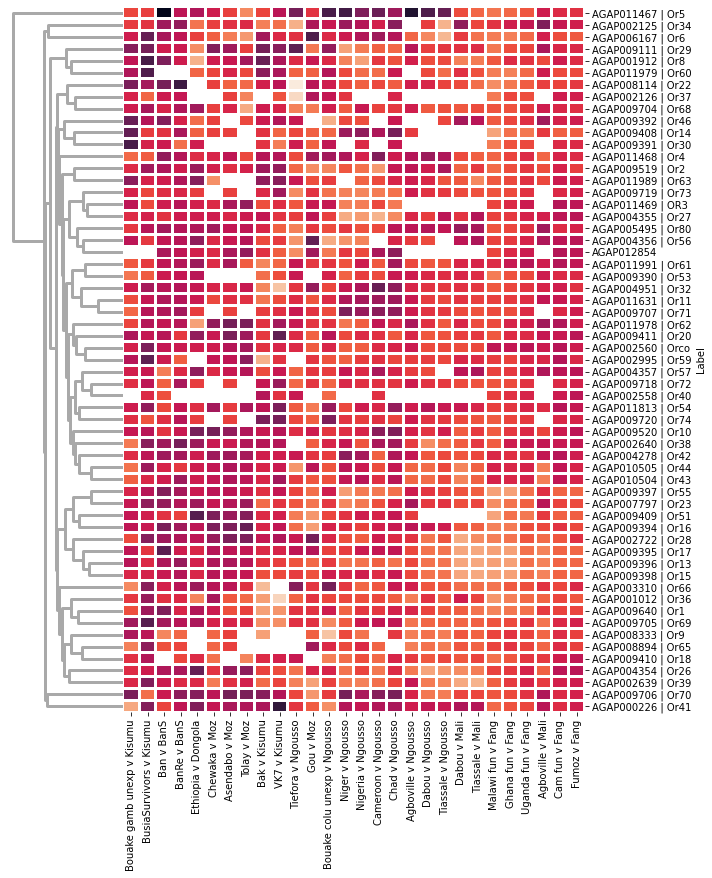

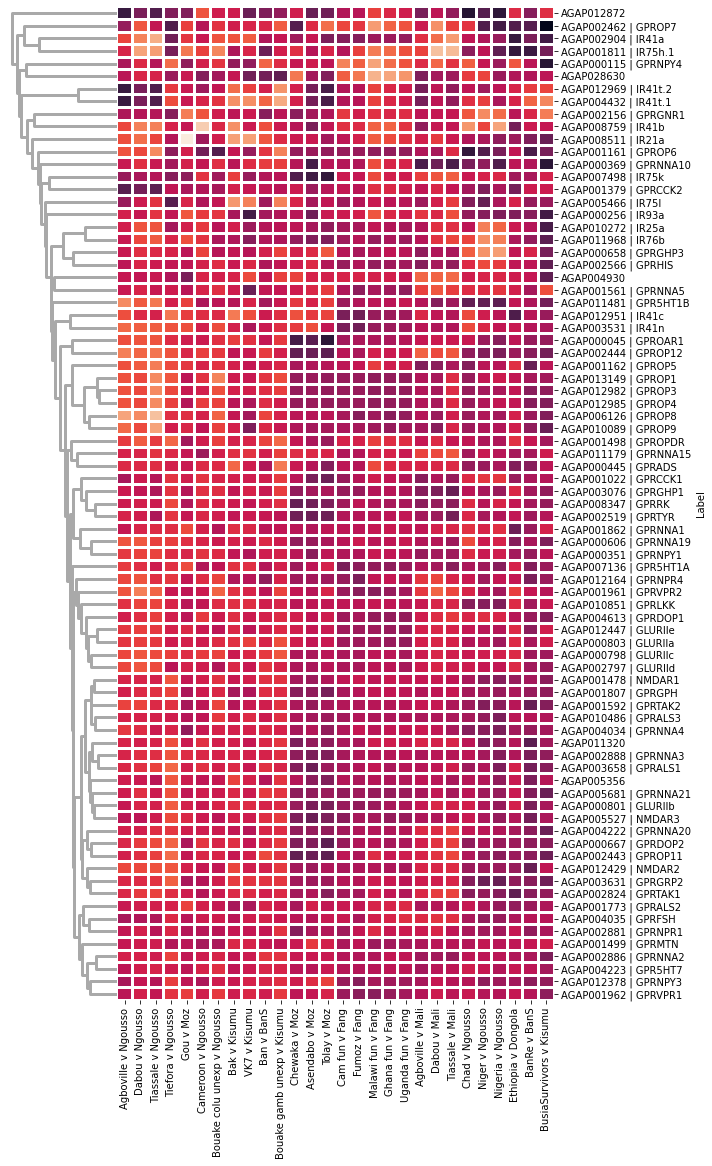

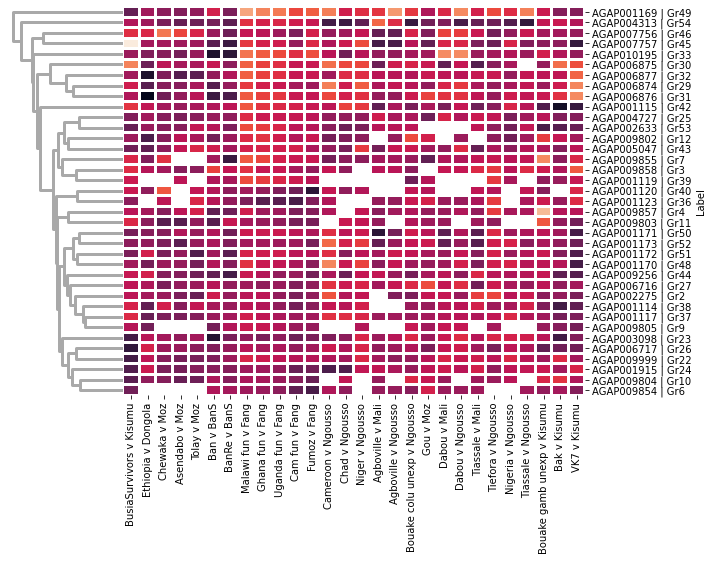

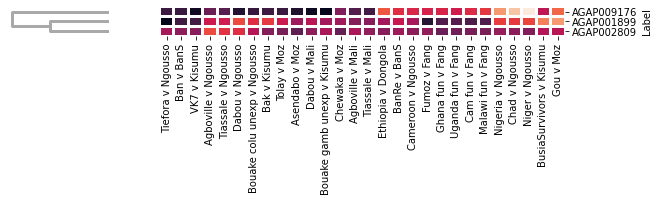

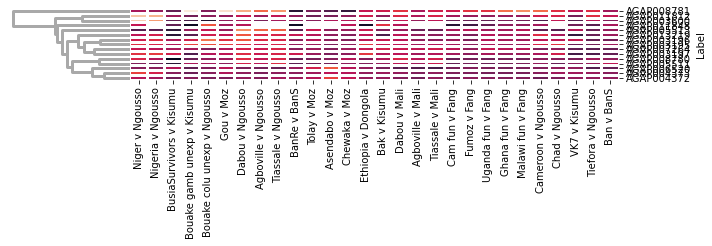

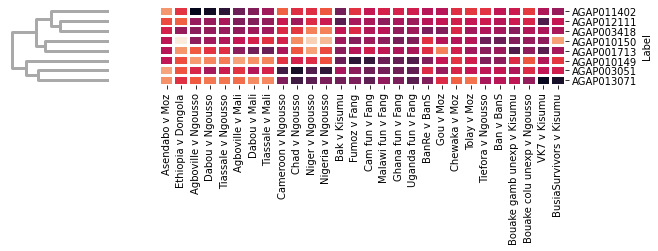

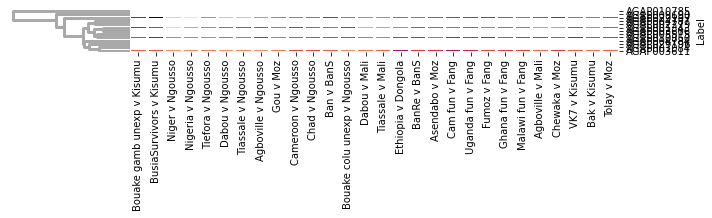

In [ ]:
 # a dict with gene families and their respective Pfam domain for extracting
gene_fams = {'Cytochrome P450s':'p450', 
             'GSTs':['GST_N', 'GST_N_3', 'GST_C'], 
             'Carboxylesterases': 'COesterase', 
             'ABC-transporters':['ABC_membrane', 'ABC_tran'],
             'CSP': 'OS-D',
             'UGTs': 'UDPGT',
             'Odorant binding proteins':'PBP_GOBP', 
             'Olfactory receptors':'7tm_6', 
             'Ionotropic receptors':['Lig_chan','7tm_1'],
             'Gustatory receptors': '7tm_7',
             'Fatty acid synthases':'ketoacyl-synt',
             'FA Elongase':'ELO',
             'FA desaturase':'FA_desaturase',
             'FA reductase':'NAD_binding_4',
             }

for fam, fam_id in gene_fams.items():

    plot_heatmap(
        analysis='gamb_colu_arab_fun',
        query_annotation=fam_id
        )

# manuscript figures 

In [2]:
 # a dict with gene families and their respective Pfam domain for extracting
gene_fams = {'Cytochrome P450s':'p450', 
             'GSTs':['GST_N', 'GST_N_3', 'GST_C'], 
             'Carboxylesterases': 'COesterase', 
             'ABC-transporters':['ABC_membrane', 'ABC_tran'],
             'CSP': 'OS-D',
             'UGTs': 'UDPGT',
             'Odorant binding proteins':'PBP_GOBP', 
             'Olfactory receptors':'7tm_6', 
             'Ionotropic receptors':['Lig_chan','7tm_1'],
             'Gustatory receptors': '7tm_7',
             'Fatty acid synthases':'ketoacyl-synt',
             'FA Elongase':'ELO',
             'FA desaturase':'FA_desaturase',
             'FA reductase':'NAD_binding_4',
             }


Too few observations for ['ABC_membrane', 'ABC_tran'] and FC of greater than 2
Too few observations for OS-D and FC of greater than 2
Too few observations for UDPGT and FC of greater than 2
Too few observations for PBP_GOBP and FC of greater than 2
Too few observations for ['Lig_chan', '7tm_1'] and FC of greater than 2
Too few observations for ketoacyl-synt and FC of greater than 2
Too few observations for ELO and FC of greater than 2
Too few observations for FA_desaturase and FC of greater than 2
Too few observations for NAD_binding_4 and FC of greater than 2


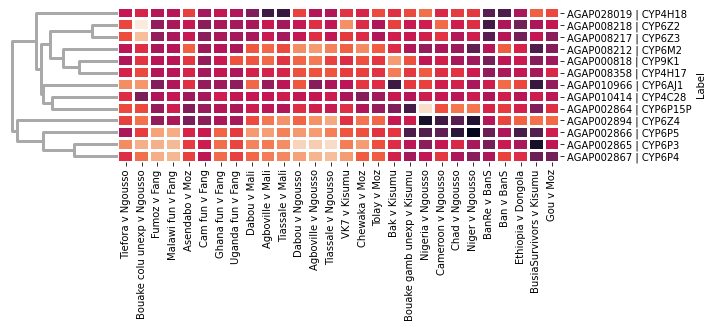

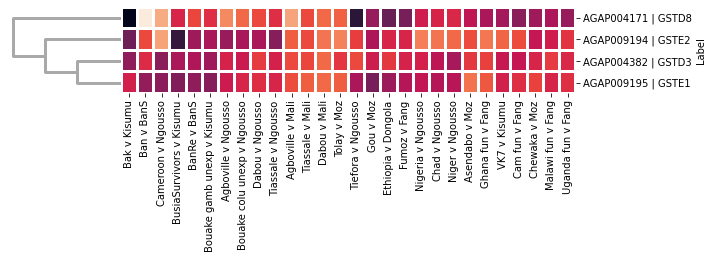

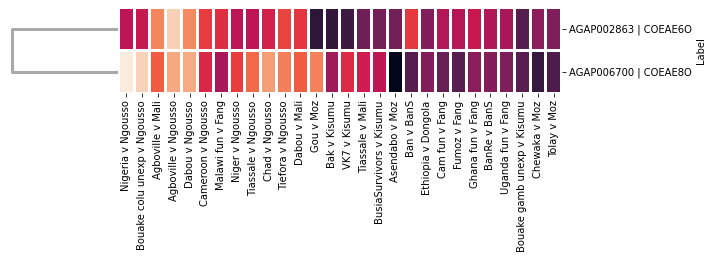

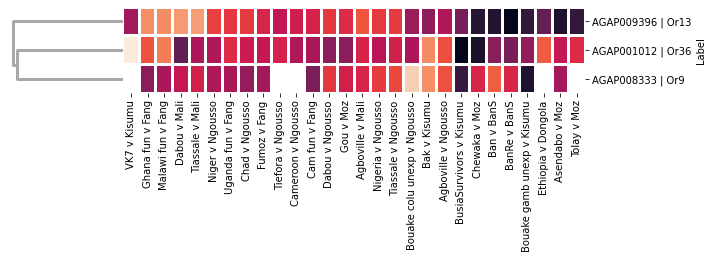

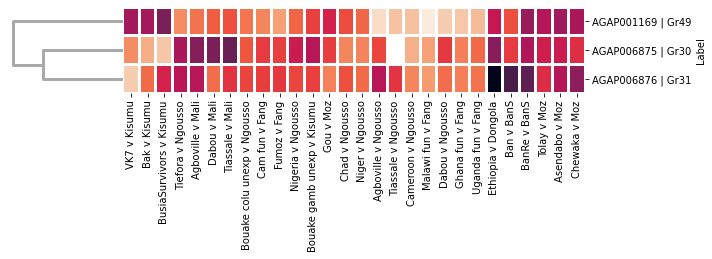

In [21]:
for fam, fam_id in gene_fams.items():
    plot_heatmap(
        analysis='gamb_colu_arab_fun',
        query_annotation=fam_id,
        query_fc=2
        )